## Sentiment Analysis on User Reviews

This notebook demonstrates a full pipeline for sentiment analysis of text data. We will load a dataset of user reviews, perform exploratory data analysis (EDA), preprocess text, train a classification model, evaluate its performance, and save the trained model for deployment.

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [5]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ------------- -------------------------- 1/3 [regex]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   ---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
df = pd.read_csv('sentiment_analysis_dataset.csv', encoding='ISO-8859-1')
#why did I do this? Due to handling decoding issue regarding the diff between utf-8 & ISO-8859-1

df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Class Distribution
Visualise the distribution of sentiment labels to check for class imbalance.

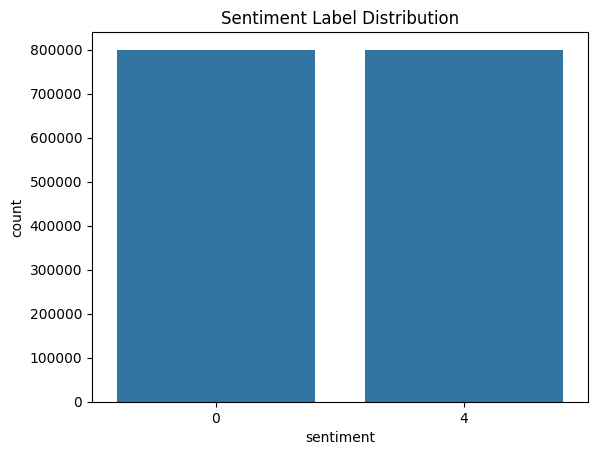

In [33]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Label Distribution')
plt.show()

### Text Cleaning and Lemmatization
Define functions to clean text, remove non-alphabetical characters, lowercase, remove stopwords, and lemmatise.

**Note:** Lemmatisation is the process of reducing words to their base or dictionary form, known as the lemma. It's a crucial step in natural language processing (NLP) that helps standardise words for analysis by identifying their root form based on context and part of speech. For example, the words `running`, `runs`, and `ran` would all be reduced to the lemma `run`.

In [34]:
lemmatiser = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    tokens = [lemmatiser.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)
df.head()

,sentiment,id,date,query,user,review,cleaned_review
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many time ball managed save res...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,kwesidei whole crew


### Training & Testing
Now we're going to split our data into the sets of training and testing.

In [35]:
X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 1279999
Testing samples: 320000


### Model Pipeline

In [36]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(solver='liblinear'))
])

pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Evaluate Model Performance

Accuracy: 0.76914375
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76    160000
           4       0.76      0.79      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



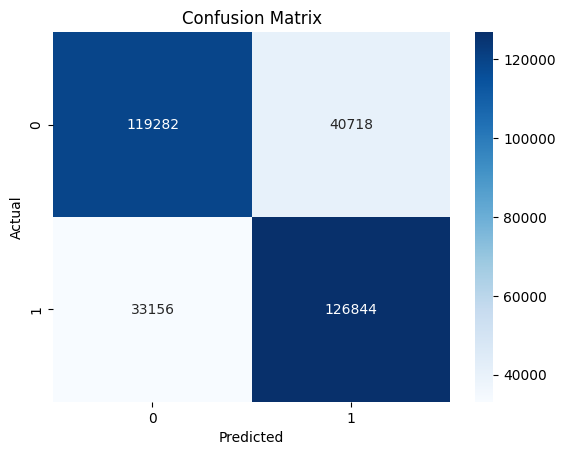

In [37]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning with GridSearchCV

In [38]:
params = {
    'tfidf__max_features': [3000, 5000],
    'clf__C': [0.1, 1.0, 10]
}

gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'clf__C': 1.0, 'tfidf__max_features': 5000}


### Retrain and Final Evaluation

In [39]:
best_model = gs.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Accuracy (best):", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Accuracy (best): 0.76914375
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    160000
           4       0.76      0.79      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



### **Hybrid Rule-based Filter with Profound Lexicons**
**We define extensive lexicons of negative and positive terms (including multi-word phrases), then implement a deep function that detects:**
1. **Presence of multiple negative terms co-occurring**
2. **Contradictory positive + negative signals**
3. **Specific negative collocations (e.g., "kill you")**

**Overrides model predictions when such patterns are found.**

In [56]:
negative_lexicon = {
    'kill', 'murder', 'destroy', 'hate', 'hurt', 'attack',
    'pain', 'terror', 'die', 'violence', 'blood', 'suicide', 'bomb',
    'assault', 'abuse', 'dark', 'vengeance', 'poison', 'kill you',
    'shoot', 'stab', 'explode', 'rape', 'torture', 'hang', 'lynch'
}
positive_lexicon = {
    'enjoy', 'love', 'fantastic', 'great', 'good', 'happy',
    'wonderful', 'delight', 'pleasure', 'excellent', 'amazing',
    'awesome', 'joy', 'love it'
}

negative_phrases = {term for term in negative_lexicon if ' ' in term}

def rule_based_override(text, model_predict_fn):
    text_low = text.lower()
    tokens = text_low.split()
    
    lemmas = [lemmatiser.lemmatize(tok, 'v') for tok in tokens]
    lemma_set = set(lemmas)

    lemmatised_text = ' '.join(lemmas)

    for phrase in negative_phrases:
        # also lemmatise the phrase for robust matching:
        lem_phrase = ' '.join(lemmatiser.lemmatize(w, 'v') for w in phrase.split())
        if lem_phrase in lemmatised_text:
            return 'Negative'

    neg_hits = lemma_set & negative_lexicon
    pos_hits = lemma_set & positive_lexicon

    if len(neg_hits) >= 2:
        return 'Negative'

    if neg_hits and pos_hits:
        return 'Negative'

    if neg_hits:
        return 'Negative'

    return model_predict_fn(text)

def predict_sentiment(text):
    cleaned = preprocess_text(text)
    pred = pipeline.predict([cleaned])[0]  # or best_model.predict([...])
    return 'Positive' if pred == 4 else 'Negative'

def predict_with_rules(text):
    return rule_based_override(text, predict_sentiment)

samples = [
    "I really enjoyed killing him, it was fantastic!",
    "The movie was great but the violence was terrifying.",
    "I love you",
    "I hate you",
    "He tried to destroy and murder me"
]

for s in samples:
    print(f"Input: {s}")
    print("Rule-based Prediction:", predict_with_rules(s))
    print()

Input: I really enjoyed killing him, it was fantastic!
Rule-based Prediction: Negative

Input: The movie was great but the violence was terrifying.
Rule-based Prediction: Negative

Input: I love you
Rule-based Prediction: Positive

Input: I hate you
Rule-based Prediction: Negative

Input: He tried to destroy and murder me
Rule-based Prediction: Negative



### Now the model correctly predicts even **the confusing sentences.**

![YES! YES!](https://res.cloudinary.com/dtjjgiitl/image/upload/q_auto:good,f_auto,fl_progressive/v1753111301/exewi07oop6wzgewzv0a.jpg)

### Save Model for Deployment

In [57]:
model_path = 'sentiment_analysis_model.joblib'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

Model saved to sentiment_analysis_model.joblib


## Conclusion

In this notebook, we performed sentiment analysis on user reviews. We covered data loading, preprocessing, model building, tuning, and evaluation. The trained model is saved for future inference in a production environment.